<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/AdaBoost(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [26]:
class AdaBoostProductionClassifier:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.feature_names = None
        self.class_names = ['Low', 'Medium', 'High']

    def load_and_preprocess_data(self, train_path, val_path, test_path):
        """Load and preprocess the datasets"""
        print("Loading datasets...")

        # Load datasets
        train_df = pd.read_csv(train_path)
        val_df = pd.read_csv(val_path)
        test_df = pd.read_csv(test_path)

        print(f"Train set shape: {train_df.shape}")
        print(f"Validation set shape: {val_df.shape}")
        print(f"Test set shape: {test_df.shape}")

        # Create labels based on production quantiles (using training data)
        production_col = 'Production (M.Ton)'

        # Calculate quantiles from training data
        quantiles = train_df[production_col].quantile([0.33, 0.67]).values
        print(f"Production quantiles - Low: <{quantiles[0]:.2f}, Medium: {quantiles[0]:.2f}-{quantiles[1]:.2f}, High: >{quantiles[1]:.2f}")

        # Create labels for all datasets
        def create_labels(df, q1, q2):
            labels = []
            for prod in df[production_col]:
                if prod <= q1:
                    labels.append('Low')
                elif prod <= q2:
                    labels.append('Medium')
                else:
                    labels.append('High')
            return labels

        train_df['Label'] = create_labels(train_df, quantiles[0], quantiles[1])
        val_df['Label'] = create_labels(val_df, quantiles[0], quantiles[1])
        test_df['Label'] = create_labels(test_df, quantiles[0], quantiles[1])

        # Separate features and labels
        feature_cols = [col for col in train_df.columns if col not in [production_col, 'Label']]
        self.feature_names = feature_cols

        X_train = train_df[feature_cols]
        y_train = train_df['Label']
        X_val = val_df[feature_cols]
        y_val = val_df['Label']
        X_test = test_df[feature_cols]
        y_test = test_df['Label']

        # Handle missing values
        X_train = X_train.fillna(X_train.mean())
        X_val = X_val.fillna(X_train.mean())  # Use training mean for consistency
        X_test = X_test.fillna(X_train.mean())

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)

        print("\nLabel distribution:")
        print("Training:", pd.Series(y_train).value_counts().sort_index())
        print("Validation:", pd.Series(y_val).value_counts().sort_index())
        print("Testing:", pd.Series(y_test).value_counts().sort_index())

        return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train_encoded, y_val_encoded, y_test_encoded,
                y_train, y_val, y_test)

    def train_model_with_epochs(self, X_train, y_train, X_val, y_val, n_epochs=100):
        """Train AdaBoost model with epoch-like iterations"""
        print(f"\nTraining AdaBoost model with {n_epochs} estimators...")

        # Initialize model
        base_estimator = DecisionTreeClassifier(max_depth=5, random_state=42)
        self.model = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_epochs,
            learning_rate=0.5,
            random_state=42
        )

        # For tracking performance over epochs
        train_accuracies = []
        val_accuracies = []
        epochs = []

        # Train with increasing number of estimators to simulate epochs
        for n_est in range(10, n_epochs + 1, 10):
            temp_model = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
                n_estimators=n_est,
                learning_rate=0.5,
                random_state=42
            )
            temp_model.fit(X_train, y_train)

            train_pred = temp_model.predict(X_train)
            val_pred = temp_model.predict(X_val)

            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            epochs.append(n_est)

            if n_est % 20 == 0:
                print(f"Estimators: {n_est}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Final training
        self.model.fit(X_train, y_train)
        print("Training completed!")

        return epochs, train_accuracies, val_accuracies

    def calculate_metrics(self, y_true, y_pred, dataset_name):
        """Calculate comprehensive classification metrics"""
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

        print(f"\n{dataset_name} Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"F1-Score (Macro): {f1_macro:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro
        }

    def plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title(f'Confusion Matrix - {title}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        return cm

    def plot_training_curves(self, epochs, train_acc, val_acc):
        """Plot training vs validation accuracy"""
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, np.array(train_acc) - np.array(val_acc), 'g-', linewidth=2)
        plt.xlabel('Number of Estimators')
        plt.ylabel('Training - Validation Accuracy')
        plt.title('Overfitting Analysis')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=15):
        """Plot feature importance"""
        if self.model is None:
            print("Model not trained yet!")
            return

        importances = self.model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importance')
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [self.feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def generate_classification_report(self, y_true, y_pred, dataset_name):
        """Generate detailed classification report"""
        print(f"\n{dataset_name} Classification Report:")
        print("=" * 50)
        report = classification_report(y_true, y_pred,
                                     target_names=self.class_names,
                                     digits=4)
        print(report)
        return report

print("✅ AdaBoostProductionClassifier class defined successfully!")

✅ AdaBoostProductionClassifier class defined successfully!


In [27]:
# Initialize classifier
classifier = AdaBoostProductionClassifier()

# File paths - UPDATE THESE PATHS TO MATCH YOUR FILE LOCATIONS
train_path = '/content/drive/MyDrive/UpdatedDataset/train.csv'
val_path = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
test_path = '/content/drive/MyDrive/UpdatedDataset/test.csv'

print("✅ Classifier initialized and file paths set!")
print(f"Train path: {train_path}")
print(f"Validation path: {val_path}")
print(f"Test path: {test_path}")

✅ Classifier initialized and file paths set!
Train path: /content/drive/MyDrive/UpdatedDataset/train.csv
Validation path: /content/drive/MyDrive/UpdatedDataset/validation.csv
Test path: /content/drive/MyDrive/UpdatedDataset/test.csv


In [28]:
print("="*60)
print("STEP 4: LOADING AND PREPROCESSING DATA")
print("="*60)

try:
    (X_train, X_val, X_test,
     y_train_enc, y_val_enc, y_test_enc,
     y_train_orig, y_val_orig, y_test_orig) = classifier.load_and_preprocess_data(
        train_path, val_path, test_path)

    print("✅ Data loading and preprocessing completed successfully!")
    print(f"Feature shape: {X_train.shape}")
    print(f"Number of features: {len(classifier.feature_names)}")

except Exception as e:
    print(f"❌ Error in data loading: {e}")
    print("Please check your file paths and ensure the CSV files exist.")

STEP 4: LOADING AND PREPROCESSING DATA
Loading datasets...
Train set shape: (3942, 84)
Validation set shape: (845, 84)
Test set shape: (845, 84)
Production quantiles - Low: <1071.56, Medium: 1071.56-4035.91, High: >4035.91

Label distribution:
Training: Label
High      1301
Low       1301
Medium    1340
Name: count, dtype: int64
Validation: Label
High      270
Low       278
Medium    297
Name: count, dtype: int64
Testing: Label
High      291
Low       274
Medium    280
Name: count, dtype: int64
✅ Data loading and preprocessing completed successfully!
Feature shape: (3942, 83)
Number of features: 83


In [29]:
print("="*60)
print("STEP 5: TRAINING MODEL")
print("="*60)

try:
    epochs, train_acc, val_acc = classifier.train_model_with_epochs(
        X_train, y_train_enc, X_val, y_val_enc, n_epochs=240)  # Reduced epochs for faster execution

    print("✅ Model training completed successfully!")
    print(f"Final training accuracy: {train_acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")

except Exception as e:
    print(f"❌ Error in model training: {e}")

STEP 5: TRAINING MODEL

Training AdaBoost model with 240 estimators...
Estimators: 20, Train Acc: 0.9219, Val Acc: 0.8828
Estimators: 40, Train Acc: 0.9417, Val Acc: 0.8852
Estimators: 60, Train Acc: 0.9602, Val Acc: 0.8876
Estimators: 80, Train Acc: 0.9660, Val Acc: 0.8817
Estimators: 100, Train Acc: 0.9688, Val Acc: 0.8864
Estimators: 120, Train Acc: 0.9772, Val Acc: 0.9006
Estimators: 140, Train Acc: 0.9774, Val Acc: 0.8947
Estimators: 160, Train Acc: 0.9810, Val Acc: 0.9006
Estimators: 180, Train Acc: 0.9858, Val Acc: 0.8935
Estimators: 200, Train Acc: 0.9863, Val Acc: 0.8994
Estimators: 220, Train Acc: 0.9883, Val Acc: 0.9006
Estimators: 240, Train Acc: 0.9932, Val Acc: 0.9018
Training completed!
✅ Model training completed successfully!
Final training accuracy: 0.9932
Final validation accuracy: 0.9018


In [30]:
print("="*60)
print("STEP 6: MAKING PREDICTIONS")
print("="*60)

try:
    train_pred = classifier.model.predict(X_train)
    val_pred = classifier.model.predict(X_val)
    test_pred = classifier.model.predict(X_test)

    print("✅ Predictions completed successfully!")
    print(f"Training predictions shape: {train_pred.shape}")
    print(f"Validation predictions shape: {val_pred.shape}")
    print(f"Test predictions shape: {test_pred.shape}")

except Exception as e:
    print(f"❌ Error in making predictions: {e}")

STEP 6: MAKING PREDICTIONS
✅ Predictions completed successfully!
Training predictions shape: (3942,)
Validation predictions shape: (845,)
Test predictions shape: (845,)


In [31]:
print("="*60)
print("STEP 7: EVALUATION METRICS")
print("="*60)

try:
    train_metrics = classifier.calculate_metrics(y_train_enc, train_pred, "TRAINING")
    val_metrics = classifier.calculate_metrics(y_val_enc, val_pred, "VALIDATION")
    test_metrics = classifier.calculate_metrics(y_test_enc, test_pred, "TESTING")

    print("✅ Metrics calculation completed successfully!")

except Exception as e:
    print(f"❌ Error in calculating metrics: {e}")

STEP 7: EVALUATION METRICS

TRAINING Metrics:
Accuracy: 0.9932
Precision (Weighted): 0.9932
Recall (Weighted): 0.9932
F1-Score (Weighted): 0.9932
F1-Score (Macro): 0.9932

VALIDATION Metrics:
Accuracy: 0.9018
Precision (Weighted): 0.9024
Recall (Weighted): 0.9018
F1-Score (Weighted): 0.9020
F1-Score (Macro): 0.9030

TESTING Metrics:
Accuracy: 0.9101
Precision (Weighted): 0.9124
Recall (Weighted): 0.9101
F1-Score (Weighted): 0.9108
F1-Score (Macro): 0.9110
✅ Metrics calculation completed successfully!


In [32]:
print("="*60)
print("STEP 8: DETAILED CLASSIFICATION REPORTS")
print("="*60)

try:
    classifier.generate_classification_report(y_train_enc, train_pred, "TRAINING")
    classifier.generate_classification_report(y_val_enc, val_pred, "VALIDATION")
    classifier.generate_classification_report(y_test_enc, test_pred, "TESTING")

    print("✅ Classification reports generated successfully!")

except Exception as e:
    print(f"❌ Error in generating classification reports: {e}")

STEP 8: DETAILED CLASSIFICATION REPORTS

TRAINING Classification Report:
              precision    recall  f1-score   support

         Low     0.9885    0.9908    0.9896      1301
      Medium     1.0000    1.0000    1.0000      1301
        High     0.9910    0.9888    0.9899      1340

    accuracy                         0.9932      3942
   macro avg     0.9932    0.9932    0.9932      3942
weighted avg     0.9932    0.9932    0.9932      3942


VALIDATION Classification Report:
              precision    recall  f1-score   support

         Low     0.9278    0.9037    0.9156       270
      Medium     0.9317    0.9317    0.9317       278
        High     0.8520    0.8721    0.8619       297

    accuracy                         0.9018       845
   macro avg     0.9038    0.9025    0.9030       845
weighted avg     0.9024    0.9018    0.9020       845


TESTING Classification Report:
              precision    recall  f1-score   support

         Low     0.9261    0.9038    0.9148

STEP 9: PLOTTING TRAINING CURVES


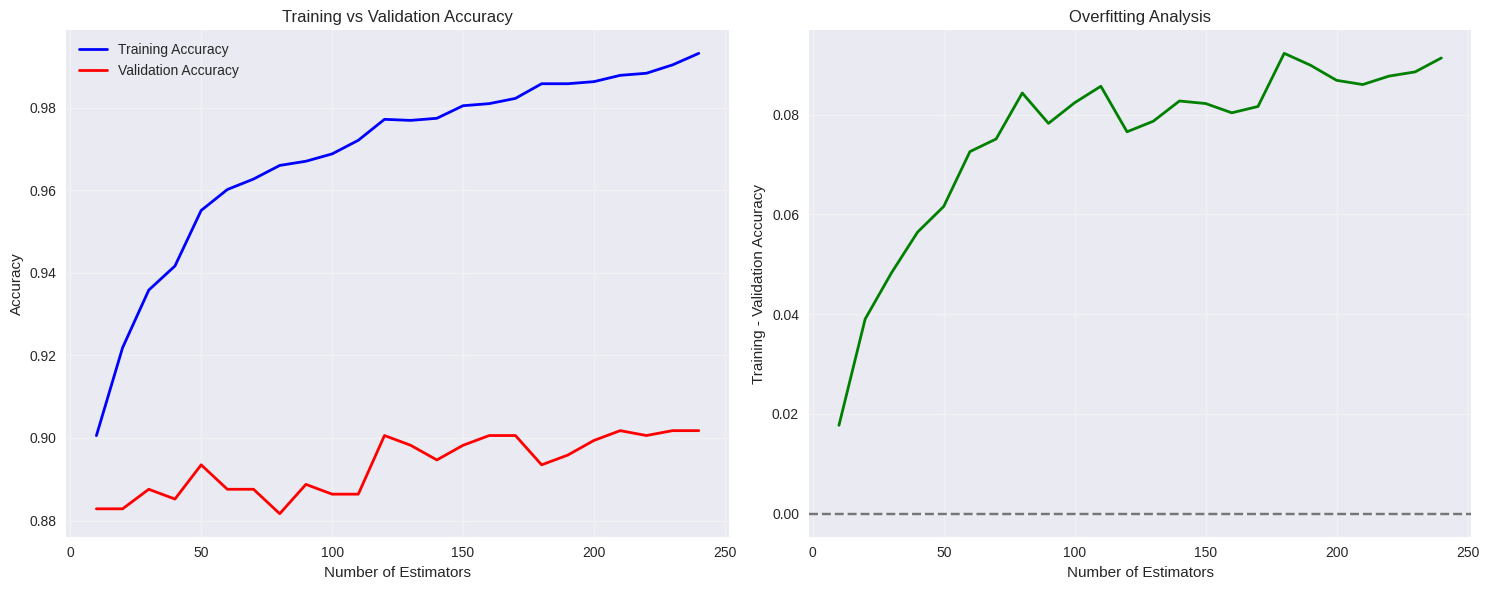

✅ Training curves plotted successfully!


In [33]:
print("="*60)
print("STEP 9: PLOTTING TRAINING CURVES")
print("="*60)

try:
    classifier.plot_training_curves(epochs, train_acc, val_acc)
    print("✅ Training curves plotted successfully!")

except Exception as e:
    print(f"❌ Error in plotting training curves: {e}")

STEP 10: PLOTTING CONFUSION MATRICES
Validation Set Confusion Matrix:


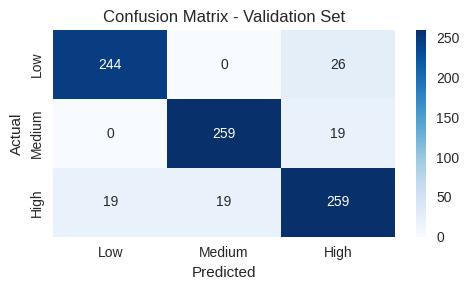


Test Set Confusion Matrix:


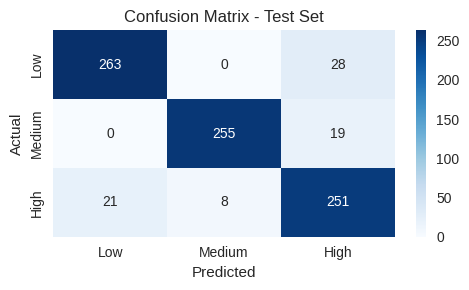

✅ Confusion matrices plotted successfully!


In [34]:
print("="*60)
print("STEP 10: PLOTTING CONFUSION MATRICES")
print("="*60)

try:
    print("Validation Set Confusion Matrix:")
    cm_val = classifier.plot_confusion_matrix(y_val_enc, val_pred, "Validation Set")

    print("\nTest Set Confusion Matrix:")
    cm_test = classifier.plot_confusion_matrix(y_test_enc, test_pred, "Test Set")

    print("✅ Confusion matrices plotted successfully!")

except Exception as e:
    print(f"❌ Error in plotting confusion matrices: {e}")

STEP 11: PLOTTING FEATURE IMPORTANCE


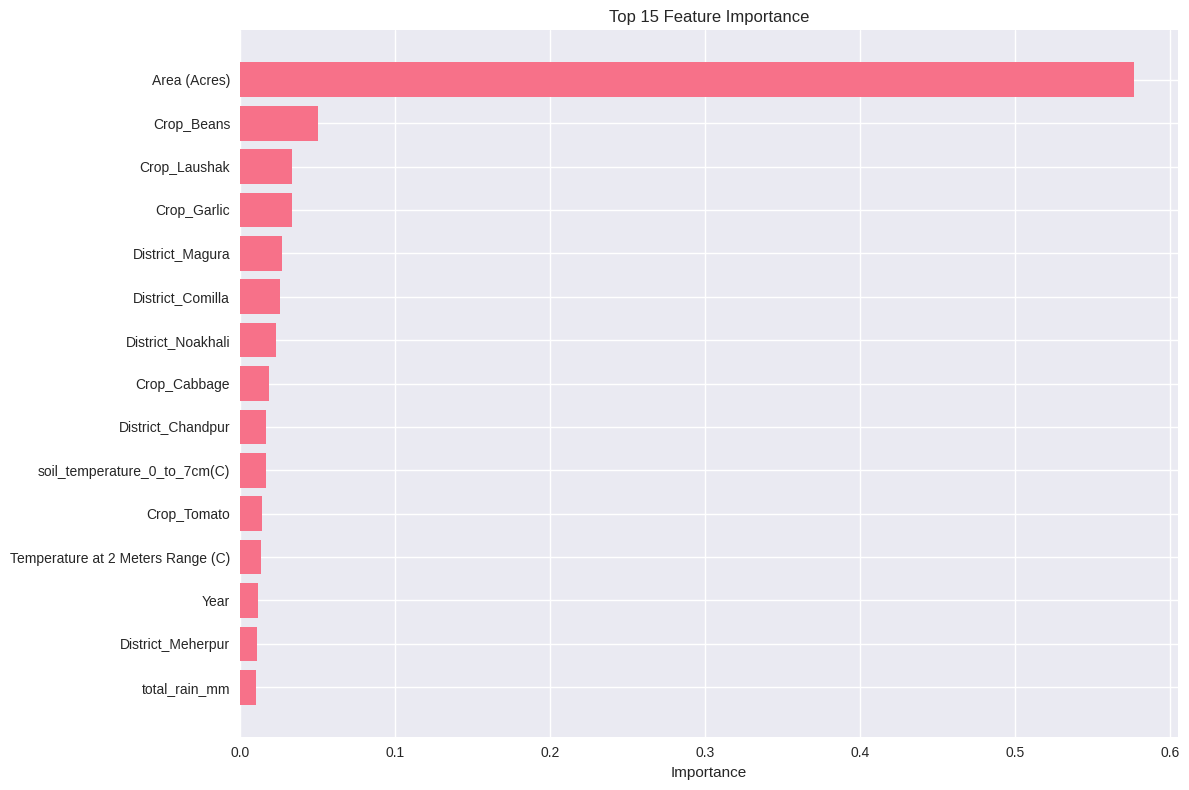

✅ Feature importance plot generated successfully!


In [35]:
print("="*60)
print("STEP 11: PLOTTING FEATURE IMPORTANCE")
print("="*60)

try:
    classifier.plot_feature_importance(top_n=15)
    print("✅ Feature importance plot generated successfully!")

except Exception as e:
    print(f"❌ Error in plotting feature importance: {e}")

In [36]:
print("="*60)
print("STEP 12: FINAL SUMMARY")
print("="*60)

try:
    summary_df = pd.DataFrame({
        'Dataset': ['Training', 'Validation', 'Testing'],
        'Accuracy': [train_metrics['accuracy'], val_metrics['accuracy'], test_metrics['accuracy']],
        'Precision': [train_metrics['precision'], val_metrics['precision'], test_metrics['precision']],
        'Recall': [train_metrics['recall'], val_metrics['recall'], test_metrics['recall']],
        'F1-Weighted': [train_metrics['f1_weighted'], val_metrics['f1_weighted'], test_metrics['f1_weighted']],
        'F1-Macro': [train_metrics['f1_macro'], val_metrics['f1_macro'], test_metrics['f1_macro']]
    })

    print("\nFinal Performance Summary:")
    print(summary_df.round(4))

    # Macro F1 Score emphasis
    print(f"\nMACRO F1 SCORES:")
    print(f"Training:   {train_metrics['f1_macro']:.4f}")
    print(f"Validation: {val_metrics['f1_macro']:.4f}")
    print(f"Testing:    {test_metrics['f1_macro']:.4f}")

    print("\n✅ All steps completed successfully!")
    print("🎉 AdaBoost Classification Pipeline Finished!")

except Exception as e:
    print(f"❌ Error in final summary: {e}")

STEP 12: FINAL SUMMARY

Final Performance Summary:
      Dataset  Accuracy  Precision  Recall  F1-Weighted  F1-Macro
0    Training    0.9932     0.9932  0.9932       0.9932    0.9932
1  Validation    0.9018     0.9024  0.9018       0.9020    0.9030
2     Testing    0.9101     0.9124  0.9101       0.9108    0.9110

MACRO F1 SCORES:
Training:   0.9932
Validation: 0.9030
Testing:    0.9110

✅ All steps completed successfully!
🎉 AdaBoost Classification Pipeline Finished!
